In [1]:
import torch
import torchaudio
from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
import datasets
import os
import pandas as pd

In [2]:
dataset_root_path = "../../data/cv-corpus-16.1-delta-2023-12-06/en"
valid_files = dataset_root_path + "/validated.tsv"

data = pd.read_csv(valid_files, sep='\t')
# keep only sentence and path columns
data = data[['path', 'sentence']]

# rename
data = data.rename(columns={'path': 'file', 'sentence': 'text'})
data 

,file,text
0,common_voice_en_39584989.mp3,These locomotives are serviced at Washwood Heath.
1,common_voice_en_39576542.mp3,"Here, she turned her inspirations towards writ..."
2,common_voice_en_39582342.mp3,There is also a garnet mine in West Redding.
3,common_voice_en_38497561.mp3,"They hastily drive to the plane, and flee from..."
4,common_voice_en_39263187.mp3,They found one such edge in Fairbairn's system.
...,...,...
3403,common_voice_en_38852923.mp3,She seems to have played little part in politics.
3404,common_voice_en_38853034.mp3,He made his film debut from movie Uma.
3405,common_voice_en_38855973.mp3,There are no known remaining records of the fi...
3406,common_voice_en_38855982.mp3,They can be described as medium-sized.


In [3]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\(\)\{\}“”\‘\-\–\—\’]'

data["text"] = data["text"].apply(lambda x: re.sub('’', "'", x))
data["text"] = data["text"].apply(lambda x: re.sub('‘', "'", x))
data["text"] = data["text"].apply(lambda x: re.sub('–', "-", x))
data["text"] = data["text"].apply(lambda x: re.sub('—', "-", x))
data["text"] = data["text"].apply(lambda x: re.sub(chars_to_ignore_regex, '', x).lower())
data["file"] = data["file"].apply(lambda x: dataset_root_path + "/clips_16k_wav/" + x.replace('.mp3', '.wav'))
data

,file,text
0,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,these locomotives are serviced at washwood heath
1,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,here she turned her inspirations towards writing
2,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,there is also a garnet mine in west redding
3,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,they hastily drive to the plane and flee from ...
4,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,they found one such edge in fairbairn's system
...,...,...
3403,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,she seems to have played little part in politics
3404,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,he made his film debut from movie uma
3405,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,there are no known remaining records of the fi...
3406,../../data/cv-corpus-16.1-delta-2023-12-06/en/...,they can be described as mediumsized


In [4]:
all_text = " ".join(data["text"])
vocab = sorted(list(set(all_text)))
vocab_dict = {v: k for k, v in enumerate(vocab)}
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
vocab_dict

import json
with open("vocab.json", "w") as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [5]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")


In [6]:
repo_name = "wav2vec2-base-cv-corpus"

In [ ]:

notebook_login()
tokenizer.push_to_hub(repo_name)


In [7]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [8]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [9]:
import IPython.display as ipd
import random
import torchaudio
audio_path = dataset_root_path + "/clips_16k_wav"

rand_int = random.randint(0, len(data))
print(f"Target text: {data['text'][rand_int]}")
audio_file = data['file'][rand_int]

waveform, sample_rate = torchaudio.load(audio_file)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Target text: he was also a berkshire county councillor


In [10]:
import pandas as pd
from datasets import Dataset

dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['file', 'text'],
    num_rows: 3408
})

In [11]:
import librosa

def preprocess_audio(batch):
    # Load the audio file
    audio, sampling_rate = librosa.load(batch["file"], sr=None)
    # Here you can add more preprocessing steps (e.g., resampling, feature extraction)
    batch["audio"] = audio
    return batch

# Apply the function to the dataset
dataset = dataset.map(preprocess_audio)
dataset

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'audio'],
    num_rows: 3408
})

In [12]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio, sampling_rate=16000).input_values
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [13]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names, batch_size=4, num_proc=1, batched=True)

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [14]:
dataset = dataset.train_test_split(test_size=0.1)

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 3067
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 341
    })
})

In [16]:
# this is from the huggingface tutorial

import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [17]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [18]:
wer_metric = load_metric("wer")

/tmp/ipykernel_10435/24688115.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [19]:
import numpy as np

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [20]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.freeze_feature_extractor()

/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1920: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [22]:
from transformers import TrainingArguments

repo_name = "wav2vec2-base-cv-corpus"

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True, 
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-2,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

In [23]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")


In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
)

In [25]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trifangrobert. Use `wandb login --relogin` to force relogin


  0%|          | 0/23010 [00:00<?, ?it/s]

/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 3.4968, 'grad_norm': 28.338380813598633, 'learning_rate': 0.000497, 'epoch': 0.65}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 2.9922573566436768, 'eval_wer': 1.0, 'eval_runtime': 21.587, 'eval_samples_per_second': 15.797, 'eval_steps_per_second': 1.992, 'epoch': 0.65}


/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.9787, 'grad_norm': 1.2683366537094116, 'learning_rate': 0.000997, 'epoch': 1.3}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 2.983794689178467, 'eval_wer': 1.0, 'eval_runtime': 22.2273, 'eval_samples_per_second': 15.342, 'eval_steps_per_second': 1.935, 'epoch': 1.3}


/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 2.974, 'grad_norm': 3.231792449951172, 'learning_rate': 0.0009774193548387096, 'epoch': 1.96}


  0%|          | 0/43 [00:00<?, ?it/s]

{'eval_loss': 2.9665706157684326, 'eval_wer': 1.0, 'eval_runtime': 22.9105, 'eval_samples_per_second': 14.884, 'eval_steps_per_second': 1.877, 'epoch': 1.96}


/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/robert/anaconda3/envs/aienv/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


KeyboardInterrupt: 

In [30]:
trainer.push_to_hub(repo_name)

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/3funnn/wav2vec2-base-cv-corpus/commit/c55ef82c4b5fe9e1a29cdb029b361c12acd38f92', commit_message='wav2vec2-base-cv-corpus', commit_description='', oid='c55ef82c4b5fe9e1a29cdb029b361c12acd38f92', pr_url=None, pr_revision=None, pr_num=None)

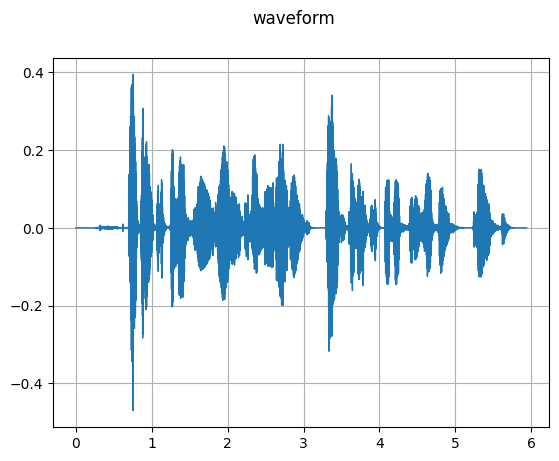

In [36]:
plot_waveform(waveform, sample_rate)

In [ ]:
# Preprocessing the data
# - Resample the audio to 16kHz
# - Convert from mp3 to wav
# - prepare for transformers trainer (batch["input_values"], batch["labels"])



In [52]:
user = "3funnn"
name = user + "/wav2vec2-base-cv-corpus"

processor = Wav2Vec2Processor.from_pretrained(name)
model = Wav2Vec2ForCTC.from_pretrained(name)
model = model.to("cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [53]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

In [54]:
results = dataset["test"].map(map_to_result, remove_columns=dataset["test"].column_names)

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

In [59]:
results[3]

{'pred_str': '',
 'text': "what does the conclusion of the lord's prayer teach us"}